### Reduce the number of rows
We re-schedule the Flink events so that they take up four rows instead of eight.

In [1]:
import json
import pandas as pd

In [2]:
df = pd.read_json('timeline.variable.flink.json')
df = df.sort_values(by=['cat', 'tid', 'ts']).reset_index(drop=True)
df['cat'].value_counts()

cat
task::MapBatches(consume)               800
task::ReadRange->MapBatches(produce)    800
Name: count, dtype: int64

In [3]:
TIME_DELTA = 1_000_000
COUNT = 0
categories = {
    'task::ReadRange->MapBatches(produce)': ['CPU:0', 'CPU:1', 'CPU:2', 'CPU:3'],
    'task::MapBatches(consume)': ['CPU:4', 'CPU:5', 'CPU:6', 'CPU:7']
}

slot_occupancy = {cpu: [] for task_cpu_list in categories.values() for cpu in task_cpu_list}
print(slot_occupancy)

def find_vacant_slot(cat, start, duration, slot_occupancy):
    """Given an event's category, start time, and duration, find a vacant slot."""
    for cpu in categories[cat]:
        conflicts = [curr for curr in slot_occupancy[cpu] if not (curr['end'] <= start or curr['start'] >= start + duration)]
        if not conflicts: 
            slot_occupancy[cpu].append({'start': start, 'end': start + duration})
            return cpu
    
    for cpu in categories[cat]:
        conflicts = [curr for curr in slot_occupancy[cpu] if not (curr['end'] <= start + TIME_DELTA or curr['start'] >= start + duration - TIME_DELTA)]
        if not conflicts: 
            slot_occupancy[cpu].append({'start': start, 'end': start + duration})
            global COUNT 
            COUNT += 1
            return cpu
    return None 

df['tid'] = df.apply(lambda row: find_vacant_slot(row['cat'], row['ts'], row['dur'], slot_occupancy), axis=1)

df.head()

{'CPU:0': [], 'CPU:1': [], 'CPU:2': [], 'CPU:3': [], 'CPU:4': [], 'CPU:5': [], 'CPU:6': [], 'CPU:7': []}


,cat,name,pid,tid,ts,dur,ph,cname,args
0,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.35.55,CPU:4,1.721595e+15,1061050.255,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
1,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.35.55,CPU:4,1.721595e+15,1062319.622,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
2,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.35.55,CPU:4,1.721595e+15,1061220.349,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
3,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.35.55,CPU:4,1.721595e+15,1063604.098,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...
4,task::MapBatches(consume),ray.data._internal.execution.operators.map_ope...,10.0.35.55,CPU:4,1.721595e+15,1057725.163,X,cq_build_passed,{'name': 'ray.data._internal.execution.operato...


In [4]:
print(len(df[df['tid'].isnull()]))

0


In [5]:
df.to_json('timeline.variable.flink.assigned.json', orient='records')

### Visualization
Ref `./long_video_plot.ipynb`

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

FIGRATIO = 2 / 5
FIGWIDTH = 10  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)

plt.rcParams.update(
    {
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True,
    }
)

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

In [10]:
producer_task_name = "task::ReadRange->MapBatches(produce)"
consumer_task_name = "task::MapBatches(consume)"

def plot_task_timeline(df, ax):
    global_start = 0
    for index, row in df.iterrows():
        if global_start == 0:
            global_start = row.name
            break
    # Populate worker id for y coordinates
    df = df[(df.index - global_start) / 1_000_000 >= 10]
    df = df[(df["cat"] == producer_task_name) | (df["cat"] == consumer_task_name)]
    unique_workers = df["tid"].unique()
    y_coordinates = {worker: index - 1 for index, worker in enumerate(unique_workers)}

    min_start = 1000
    ax.plot([0, 0], [0, 0])  # Note: for add_patch to work
    for index, row in df.iterrows():
        start_time = (index - global_start) / 1_000_000
        min_start = min(min_start, start_time)
        duration = row["dur"] / 1_000_000
        task_name = row["cat"]
        worker = row["tid"]
        y_coordinate = y_coordinates[worker]

        color_index = 1 if task_name == producer_task_name else 2
        color = COLORS[color_index]

        ax.add_patch(
            plt.Rectangle(
                (start_time - min_start, y_coordinate),
                duration,
                0.5,
                fill=True,
                facecolor=color,
                edgecolor="grey",
                linewidth=0.01,
                zorder=100,
            )
        )

    ax.set_xlabel("Time (s)", fontsize=20)
    ax.yaxis.set_visible(False)
    ax.tick_params(axis="x", labelsize=20)

Text(0.5, 1.0, 'timeline.variable.flink.assigned')

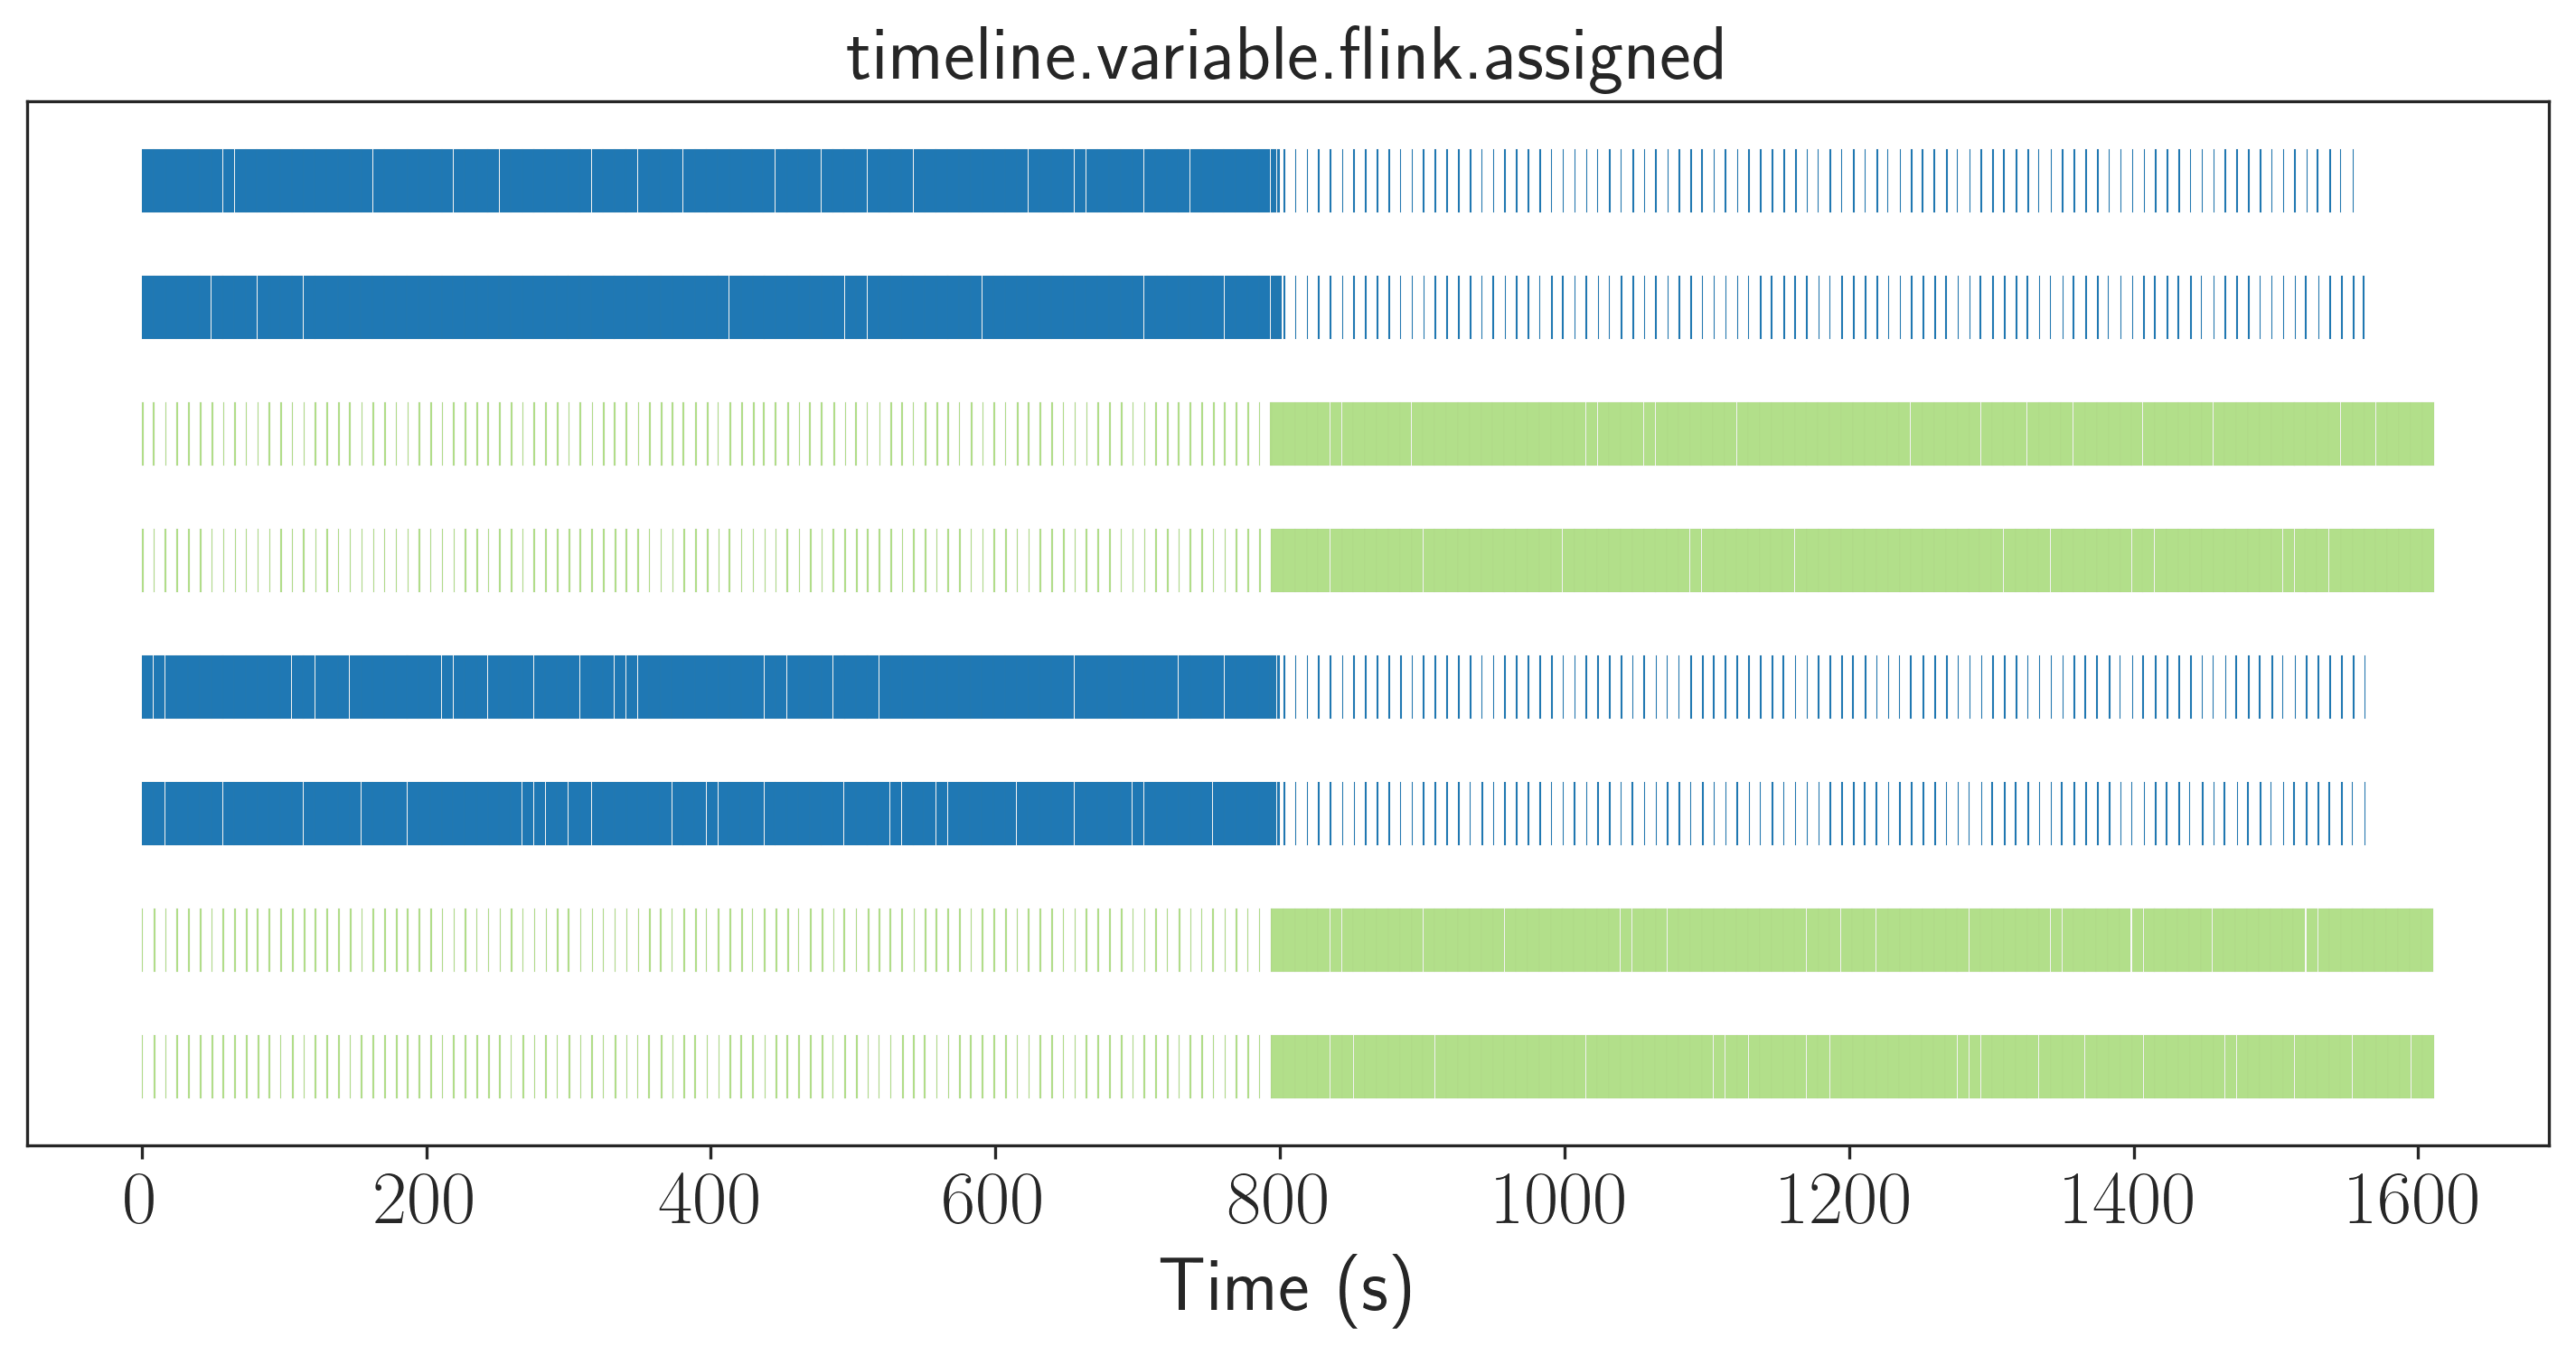

In [11]:
file_path = "/home/ubuntu/ray-data-eval/ray_data_eval/video_inference/plotting/timeline.variable.flink.assigned.json"

fig, axs = plt.subplots(1, 1, figsize=(12, 5))

df = pd.read_json(file_path)
df.set_index("ts", inplace=True)
df.sort_index(inplace=True)
plot_task_timeline(df, axs)
file_name = os.path.basename(file_path)[:-5]
plot_task_timeline(df, axs)
axs.set_title(file_name, fontsize=20)

### Discussion: mapping problem is NP-hard
We can reduce the 8 -> 4 mapping problem to the graph coloring problem.

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(events):
    G = nx.Graph()
    for i, event in enumerate(events):
        G.add_node(i, start=event['ts'], duration=event['dur'], end=event['ts'] + event['dur'])

    for i in range(len(events)):
        for j in range(i + 1, len(events)):  
            # Event j starts before event i ends, and event i starts before event j ends
            if (events[i]['ts'] < events[j]['ts'] + events[j]['dur'] and
                events[j]['ts'] < events[i]['ts'] + events[i]['dur'] ):
                G.add_edge(i, j)

    return G


def color_graph(G):
    coloring = nx.coloring.greedy_color(G, strategy="saturation_largest_first")
    return coloring

In [7]:
events = json.loads(open('timeline.variable.flink.json').read())
print(len(events))
G = build_graph(events)

1600


In [12]:
coloring = color_graph(G)
print("Coloring of the graph (each number represents a different slot):", coloring)
print("Number of slots used:", max(coloring.values()) + 1)

Coloring of the graph (each number represents a different slot): {708: 0, 304: 1, 903: 2, 1498: 3, 1104: 4, 104: 5, 508: 6, 1304: 7, 1103: 4, 103: 5, 507: 6, 1303: 7, 1102: 4, 102: 5, 506: 6, 1302: 7, 1101: 4, 101: 5, 505: 6, 1301: 7, 1100: 4, 100: 5, 504: 6, 1300: 7, 1099: 4, 105: 1, 305: 2, 509: 3, 904: 5, 1305: 6, 1499: 7, 709: 0, 1105: 4, 306: 1, 905: 2, 1500: 3, 510: 0, 106: 4, 710: 5, 1306: 6, 1106: 7, 1107: 3, 107: 1, 1307: 2, 511: 0, 1501: 4, 307: 5, 711: 6, 906: 7, 308: 1, 907: 2, 1308: 3, 1108: 0, 1502: 4, 108: 5, 712: 6, 512: 7, 513: 3, 109: 1, 713: 2, 1109: 0, 1309: 4, 309: 5, 908: 6, 1503: 7, 1504: 3, 310: 1, 909: 2, 514: 0, 714: 4, 1310: 5, 110: 6, 1110: 7, 1111: 3, 111: 1, 715: 2, 515: 0, 1505: 4, 910: 5, 311: 6, 1311: 7, 1312: 3, 312: 1, 911: 2, 1112: 0, 1506: 4, 112: 5, 716: 6, 516: 7, 517: 3, 717: 1, 113: 2, 1113: 0, 1313: 4, 313: 5, 912: 6, 1507: 7, 1508: 3, 913: 1, 314: 2, 518: 0, 1314: 4, 718: 5, 114: 6, 1114: 7, 115: 1, 1115: 3, 719: 2, 519: 0, 914: 4, 315: 5, 131